In [31]:
# notebook last tested with abtem version 1.0.0beta13

from abtem import __version__
print('current version:', __version__)

from ase.io import read
import matplotlib.pyplot as plt

from abtem import *
from abtem.utils import ProgressBar

current version: 1.0.0beta24


# PACBED thickness series (no PRISM)

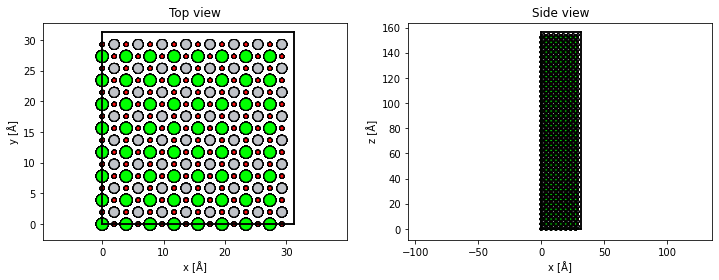

In [4]:
atoms = read('../data/srtio3_100.cif')

atoms *= (8, 8, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');

In [38]:
potential = Potential(atoms, 
                      gpts=512, 
                      device='cpu', 
                      projection='infinite', 
                      slice_thickness=atoms.cell[2,2] / 80, 
                      parametrization='kirkland')

In [39]:
detectors = [PixelatedDetector(max_angle=60)]

end = (potential.extent[0] / 8, potential.extent[1] / 8)
scan = GridScan(start=[0, 0], end=end, sampling=.2)

probe = Probe(energy=80e3, semiangle_cutoff=20, device='cpu')
probe.grid.match(potential)

In [40]:
# save after every eighth slice
save_every = 8

chunks = [(i, i + save_every) for i in range(0, len(potential), save_every)] 

In [41]:
# Allocate on measurement for each detector for each output thickness
measurements = [probe._validate_scan_measurements(detectors, scan) for chunk in chunks]

max_batch = 50 # propagate 50 probes at a time, lower or increase this based on memory

pbar = ProgressBar(desc='Positions', total=len(scan))

for indices, positions in scan.generate_positions(max_batch=max_batch):
    waves = probe.build(positions)
    
    for chunk_idx, (start_slice, end_slice) in enumerate(chunks):
        potential_slices = potential[start_slice:end_slice]
        waves = waves.multislice(potential_slices, pbar=False)
        
        for detector in detectors:
            new_measurements = detector.detect(waves)
            scan.insert_new_measurement(measurements[chunk_idx][detector], indices, new_measurements)
    
    pbar.update(len(positions))

pbar.close()

Positions:   0%|          | 0/400 [00:00<?, ?it/s]

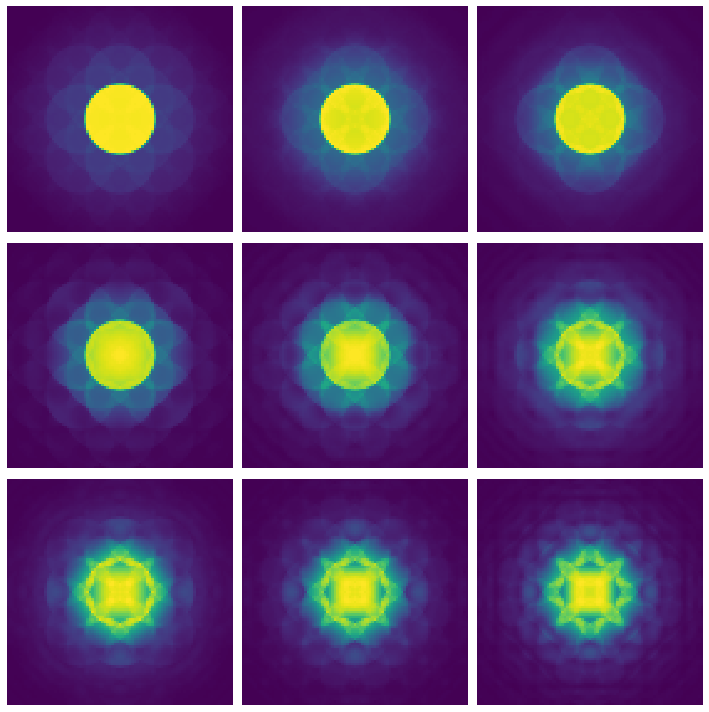

In [29]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.ravel()):
    measurements[i][detectors[0]].sum((0,1)).show(ax=ax, cmap='viridis', power=.5, title='')
    ax.axis('off')

plt.tight_layout()